In [1]:
#All imports

import yfinance as yf
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import mplfinance as mpf

In [2]:
def plot_candle(symbol, interval, period):
    #Candlestick plotter using matplotlib finance
    ticker = yf.Ticker(symbol).history(interval = interval, period = period, prepost = True)
    mpf.plot(ticker, type = 'candle', style = 'charles', ylabel = 'Price')

In [3]:
def plot_line(symbol, interval, period):
    #LIne graph plotter using matplotlib finance library
    ticker = yf.Ticker(symbol).history(interval = interval, period = period, prepost = True)
    mpf.plot(ticker, type = 'line', style = 'charles', ylabel = 'Price')

In [4]:
def create_ticker(symbol, interval, period):
    #Returns pandas dataframe with datetime, open, close, high, low, volume etc.
    ticker = yf.Ticker(symbol).history(interval = interval, period = period, prepost = True)
    # Reset the index to convert it to a column
    ticker.reset_index(inplace=True)
    ticker = add_emv(ticker)
    return ticker

In [6]:
def add_sma(ticker):
    #adds simple moving averages
    # Add a 20-day moving average
    ticker['SMA_20'] = ticker['Close'].rolling(window=20).mean()

    # Add a 50-day moving average
    ticker['SMA_50'] = ticker['Close'].rolling(window=50).mean()

    # Add a 200-day moving average
    ticker['SMA_200'] = ticker['Close'].rolling(window=200).mean()
    return ticker

In [7]:
def add_emv(ticker):
    # Add a 20-day exponential moving average
    ticker['EMA_20'] = ticker['Close'].ewm(span=20, adjust=False).mean()

    # Add a 50-day exponential moving average
    ticker['EMA_50'] = ticker['Close'].ewm(span=50, adjust=False).mean()

    # Add a 200-day exponential moving average
    ticker['EMA_200'] = ticker['Close'].ewm(span=200, adjust=False).mean()
    return ticker


In [65]:
def separate_date(df_train):
#Separate dates for future plotting
    train_dates = pd.to_datetime(df_train['Date'])
    return train_dates

In [69]:
def normalise(df_train):
    scaler = StandardScaler()
    scaler = scaler.fit(df_train)
    df_train_scaled = scaler.transform(df_train)
    return df_train_scaled

In [68]:
def preprocess_data(data, n_past, n_future):
    # Print the input data to verify
    print("Input Data:", data)
    
    
    X, Y = [], []

    # Add your data preprocessing logic here
    # For example:
    for i in range(n_past, len(df_train) - n_future + 1):
        X.append(df_train[i - n_past:i, 0:data.shape[1]])
        Y.append(df_train[i:i + n_future, 0])

    X, Y = np.array(X), np.array(Y)

    # Print the shapes of X and y to verify they are as expected
    print("X shape:", X.shape)
    print("y shape:", Y.shape)

    return X, Y

In [72]:
def train_cols(ticker, cols):
      df_train = ticker[cols].astype(float)
      return df_train

In [43]:
n_future = 7   # Number of days we want to look into the future based on the past days
n_past = 150    # Number of past days we want to use to predict the future


In [105]:
def fit_LSTM(trainX, trainY):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Fit the model
    history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()
    return model

In [107]:
def predict(model, days_for_prediction):
    prediction = model.predict(testX[-days_for_prediction:]) 
    #Rescale back to original range
    prediction_copies = np.repeat(prediction, df_for_testing.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:, 3]
    return y_pred_future


In [20]:
ticker = create_ticker('AAPL', '1d', '1y')

In [21]:
ticker

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_20,EMA_50,EMA_200
0,2023-07-05 00:00:00-04:00,190.558013,191.960552,189.613019,190.319275,46920300,0.0,0.0,190.319275,190.319275,190.319275
1,2023-07-06 00:00:00-04:00,188.837143,191.005635,188.200525,190.796738,45094300,0.0,0.0,190.364748,190.337999,190.324026
2,2023-07-07 00:00:00-04:00,190.398838,191.652177,189.235021,189.672684,46778000,0.0,0.0,190.298837,190.311908,190.317545
3,2023-07-10 00:00:00-04:00,188.260192,188.986347,186.051919,187.613632,59922200,0.0,0.0,190.043103,190.206093,190.290640
4,2023-07-11 00:00:00-04:00,188.160722,188.299982,185.614248,187.086426,46638100,0.0,0.0,189.761515,190.083753,190.258757
...,...,...,...,...,...,...,...,...,...,...,...
247,2024-06-27 00:00:00-04:00,214.690002,215.740005,212.350006,214.100006,49772700,0.0,0.0,205.202150,194.722179,185.831715
248,2024-06-28 00:00:00-04:00,215.770004,216.070007,210.300003,210.619995,82542700,0.0,0.0,205.718135,195.345623,186.078365
249,2024-07-01 00:00:00-04:00,212.089996,217.509995,211.919998,216.750000,60402900,0.0,0.0,206.768789,196.185010,186.383555
250,2024-07-02 00:00:00-04:00,216.149994,220.380005,215.100006,220.270004,58046200,0.0,0.0,208.054619,197.129520,186.720734


In [66]:
train_dates = separate_date(ticker)

In [67]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_20', 'EMA_50', 'EMA_200']

In [73]:
df_train_scaled = normalise(train_cols(ticker, cols))

In [74]:
df_train_scaled

array([[0.58239068, 0.55567913, 0.63433385, ..., 0.83797415, 1.26237065,
        1.82803185],
       [0.43102675, 0.47306236, 0.50876159, ..., 0.84341039, 1.26572452,
        1.8297659 ],
       [0.56839006, 0.52899932, 0.60072942, ..., 0.83553077, 1.26105111,
        1.82740035],
       ...,
       [2.47629721, 2.76614473, 2.61744849, ..., 2.80450882, 2.31304694,
        0.3915086 ],
       [2.83340578, 3.01444992, 2.90015465, ..., 2.95822942, 2.48222842,
        0.51457756],
       [3.17204395, 3.11567486, 3.24953526, ..., 3.11188364, 2.6537665 ,
        0.64107065]])

In [82]:
trainX = []
trainY = []

n_future = 7   # Number of days we want to look into the future based on the past days.
n_past = 150  # Number of past days we want to use to predict the future.

n_features = df_train_scaled.shape[1]

# Initialize lists to store the sequences
trainX, trainY = [], []

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_train_scaled) - n_future + 1):
    trainX.append(df_train_scaled[i - n_past:i, 0:n_features])
    trainY.append(df_train_scaled[i + n_future - 1:i + n_future, 3])
    

trainX, trainY = np.array(trainX), np.array(trainY)


In [84]:
trainX

array([[[ 0.58239068,  0.55567913,  0.63433385, ...,  0.83797415,
          1.26237065,  1.82803185],
        [ 0.43102675,  0.47306236,  0.50876159, ...,  0.84341039,
          1.26572452,  1.8297659 ],
        [ 0.56839006,  0.52899932,  0.60072942, ...,  0.83553077,
          1.26105111,  1.82740035],
        ...,
        [-0.40014584,  0.11247716, -0.32881563, ...,  0.62243175,
          0.83875915,  0.3014707 ],
        [ 0.32710839,  0.27815368,  0.25550313, ...,  0.60729558,
          0.83336861,  0.30528426],
        [ 0.21394139,  0.28333076,  0.33796453, ...,  0.61199742,
          0.83953907,  0.31492798]],

       [[ 0.43102675,  0.47306236,  0.50876159, ...,  0.84341039,
          1.26572452,  1.8297659 ],
        [ 0.56839006,  0.52899932,  0.60072942, ...,  0.83553077,
          1.26105111,  1.82740035],
        [ 0.38027941,  0.29835926,  0.31774819, ...,  0.80495787,
          1.24209747,  1.81758027],
        ...,
        [ 0.32710839,  0.27815368,  0.25550313, ...,  

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 150, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.2142 - val_loss: 5.9620
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8048 - val_loss: 1.9198
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8180 - val_loss: 0.7195
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: nan - val_loss: nan
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: nan - val_loss: nan


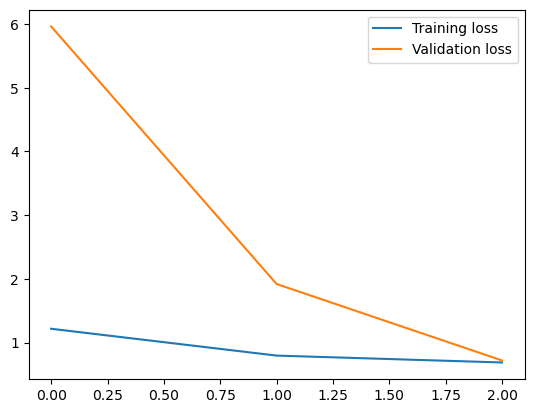

In [106]:
model = fit_LSTM(trainX, trainY)

[Timestamp('2023-11-28 00:00:00-0500', tz='America/New_York'), Timestamp('2023-11-29 00:00:00-0500', tz='America/New_York'), Timestamp('2023-11-30 00:00:00-0500', tz='America/New_York'), Timestamp('2023-12-01 00:00:00-0500', tz='America/New_York'), Timestamp('2023-12-02 00:00:00-0500', tz='America/New_York'), Timestamp('2023-12-03 00:00:00-0500', tz='America/New_York'), Timestamp('2023-12-04 00:00:00-0500', tz='America/New_York')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[nan nan nan nan nan nan nan]


,Date,Close
0,2023-11-28,NaN
1,2023-11-29,NaN
2,2023-11-30,NaN
3,2023-12-01,NaN
4,2023-12-02,NaN
5,2023-12-03,NaN
6,2023-12-04,NaN


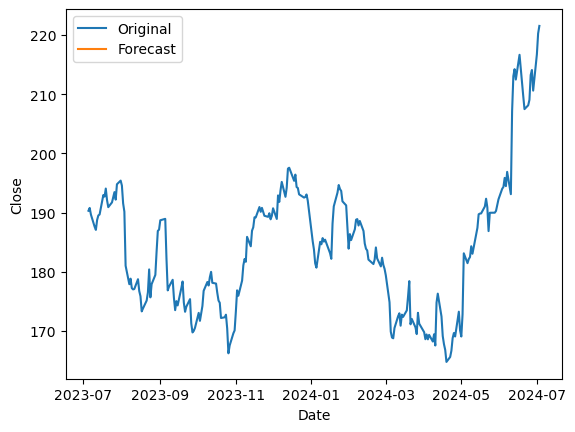

In [117]:
n_days_for_prediction = 7
scaler = StandardScaler()
scaler = scaler.fit(df_train)
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

#Original and df_forecast DataFrames are already defined
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

# Plotting with Seaborn
sns.lineplot(data=original, x='Date', y='Close', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='Close', label='Forecast')

df_forecast
